<a href="https://colab.research.google.com/github/JNK234/100-days-of-deep-learning/blob/main/Day-15/Text_Classification_using_HuggingFace_Chapter_2_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs

In [ ]:
!pip install transformers[sentencepiece]
!pip install datasets
!pip install umap-learn -q

## The Dataset

Let's use the sentiment analysis dataset for this notebook. Thiw will classify tweets into 6 emotions: anger, disgust, fearr, joy, sadness and surprise. 

Let's use the HuggingFace Hub to download the dataset

In [3]:
from datasets import list_datasets

In [4]:
all_datasets = list_datasets()

print(f'There are {len(all_datasets)} datasets currently available on the Hub.')
print(f'The frisst 10 datasets are: {all_datasets[:10]}')

There are 3894 datasets currently available on the Hub.
The frisst 10 datasets are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [5]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions["train"]

In [8]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
len(train_ds)

16000

In [10]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

In [11]:
train_ds.column_names

['text', 'label']

In [12]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [13]:
train_ds[:5]

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

In [14]:
train_ds['text'][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [15]:
import pandas as pd

emotions.set_format(type="pandas")

In [16]:
df = emotions["train"][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [17]:
df["label"].value_counts()

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [18]:
df["label"].isnull().sum()

0

In [19]:
emotions["train"].features["label"].int2str(4)

'fear'

In [20]:
df["label_name"] = df["label"].apply(lambda x: emotions["train"].features["label"].int2str(x))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


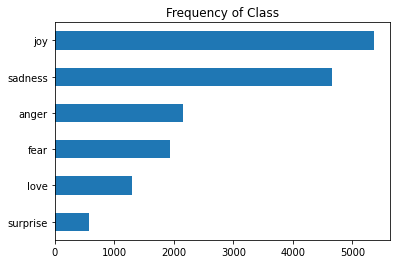

In [21]:
# Check the class distribution
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Class")
plt.show()

The dataset is heavily imbalanced. 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


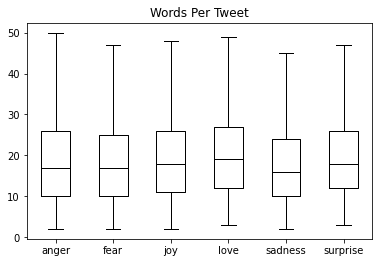

In [22]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the above graph, we can see that most of the lengths of the tweets in our dataset has a length of 15 and the maximum is below the maximum context size of the DistilBERT model we ae using to train i.e. 512 tokens

In [23]:
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


Now since we don't need to use Pandas anymore for data, let's convert it back to DataSet Format

In [24]:
emotions.reset_format()

In [25]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Form Text to Tokens

### CHaracter Tokenization

In [26]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


In [27]:
token2idx = {ch:idx for idx,ch in enumerate(sorted(set(tokenized_text)))}
token2idx

{' ': 0,
 'L': 1,
 'N': 2,
 'P': 3,
 'T': 4,
 'a': 5,
 'c': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'i': 10,
 'k': 11,
 'n': 12,
 'o': 13,
 'r': 14,
 's': 15,
 't': 16,
 'x': 17,
 'z': 18}

In [28]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


In [29]:
max(input_ids)

18

In [30]:
# One Hot encoding example
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]}
)
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


We should perform one-hot encoding on categorical data because, the above data creates a fictional heirarchial relationship between characters and neural networks learns about it.  

In [31]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


Therefore now let's one-hot encode the input-ids using pytorch

In [32]:
import torch
import torch.nn.functional as F

In [33]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

In [34]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization

In [35]:
tokenized_text = text.split()
tokenized_text

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']

### Subword Tokenization

In [36]:
from transformers import AutoTokenizer

In [37]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [38]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [39]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [40]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp [SEP]'

In [41]:
tokenizer.vocab_size

30522

In [42]:
tokenizer.model_max_length

512

In [43]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Always use the same tokenizer along with the model from the same checkpoint.

In [44]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [45]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Special Token - Special Token ID Mapping

* [PAD] - 0
* [UNK] - 100
* [CLS] -  101
* [SEP] - 102
* [MASK] - 103

In [46]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [47]:
emotions_encoded['train'][0]['text']

'i didnt feel humiliated'

In [48]:
len(emotions_encoded['train'][0]['input_ids'])

87

In [49]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

### Transformers as Feature Extractors

In [50]:
from transformers import AutoModel

In [51]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [53]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs=model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [54]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [55]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [56]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [57]:
def extract_gidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state=model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [58]:
emotions_encoded.set_format("pandas")

df1 = emotions_encoded['train'][:]

In [59]:
df1

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,"[101, 1045, 2074, 2018, 1037, 2200, 4766, 2051...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15996,i am now turning and i feel pathetic that i am...,0,"[101, 1045, 2572, 2085, 3810, 1998, 1045, 2514...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15997,i feel strong and good overall,1,"[101, 1045, 2514, 2844, 1998, 2204, 3452, 102,...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
15998,i feel like this was such a rude comment and i...,3,"[101, 1045, 2514, 2066, 2023, 2001, 2107, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [60]:
emotions_encoded.reset_format()

In [61]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [62]:
emotions_hidden = emotions_encoded.map(extract_gidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [63]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [64]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [65]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [66]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [67]:
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.718783,6.587046,0
1,-2.564714,6.199209,0
2,5.581466,3.112958,3
3,-2.269851,3.897372,2
4,-3.140041,4.364894,3


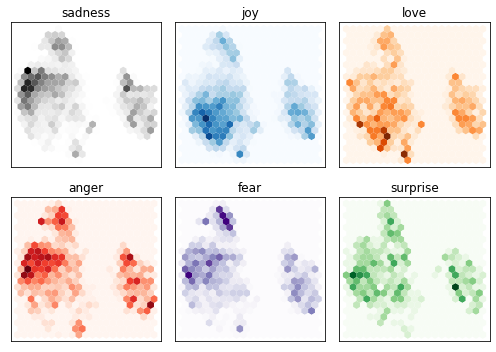

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [69]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [70]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

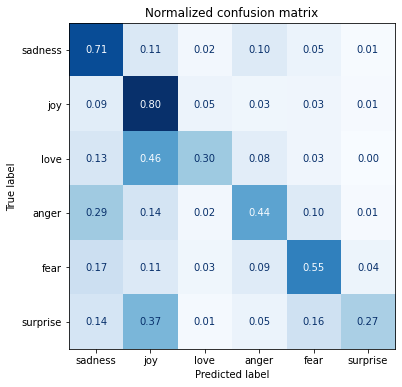

In [72]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-tuning Transformers

In [73]:
from transformers import AutoModelForSequenceClassification

In [74]:
num_labels = len(emotions_encoded['train'].features['label'].names)

model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [75]:
# Define compute_metrics() function 
from sklearn.metrics import accuracy_score, f1_score 

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, 
            "f1": f1}

In [76]:
from huggingface_hub import notebook_login

In [78]:
!git config --global credential.helper store

In [79]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [80]:
from transformers import Trainer, TrainingArguments

In [81]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size 
model_name = f"{model_ckpt}-finetuned-emotion"

In [82]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [83]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

Cloning https://huggingface.co/JNK789/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.98k/2.98k [00:00<?, ?B/s]

Clean file training_args.bin:  34%|###3      | 1.00k/2.98k [00:00<?, ?B/s]

Download file runs/Mar31_18-46-12_5f1fe8e9cddc/events.out.tfevents.1648752842.5f1fe8e9cddc.72.0: 100%|########…

Clean file runs/Mar31_18-46-12_5f1fe8e9cddc/events.out.tfevents.1648752842.5f1fe8e9cddc.72.0:  21%|##        |…

Download file runs/Mar31_19-04-28_5f1fe8e9cddc/events.out.tfevents.1648753484.5f1fe8e9cddc.72.2: 100%|########…

Clean file runs/Mar31_19-04-28_5f1fe8e9cddc/events.out.tfevents.1648753484.5f1fe8e9cddc.72.2:  19%|#9        |…

Download file runs/Mar31_19-04-28_5f1fe8e9cddc/1648753484.6354618/events.out.tfevents.1648753484.5f1fe8e9cddc.…

Clean file runs/Mar31_19-04-28_5f1fe8e9cddc/1648753484.6354618/events.out.tfevents.1648753484.5f1fe8e9cddc.72.…

Download file runs/Mar31_18-46-12_5f1fe8e9cddc/1648752842.1680079/events.out.tfevents.1648752842.5f1fe8e9cddc.…

Clean file runs/Mar31_18-46-12_5f1fe8e9cddc/1648752842.1680079/events.out.tfevents.1648752842.5f1fe8e9cddc.72.…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [84]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.772100,0.277759,0.914500,0.913144
2,0.210300,0.181794,0.925000,0.924905
3,0.144600,0.171247,0.930500,0.930795


TrainOutput(global_step=750, training_loss=0.37565304056803384, metrics={'train_runtime': 663.1577, 'train_samples_per_second': 72.381, 'train_steps_per_second': 1.131, 'total_flos': 1080514292544000.0, 'train_loss': 0.37565304056803384, 'epoch': 3.0})

In [85]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [86]:
preds_output.metrics

{'test_accuracy': 0.9305,
 'test_f1': 0.9307950942842982,
 'test_loss': 0.17124703526496887,
 'test_runtime': 8.5226,
 'test_samples_per_second': 234.669,
 'test_steps_per_second': 3.755}

In [87]:
y_preds = np.argmax(preds_output.predictions, axis=1)

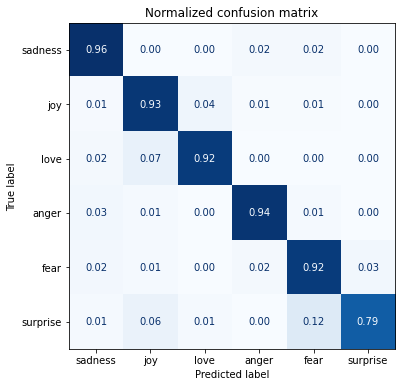

In [88]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Error Analysis

In [89]:
from torch.nn.functional import cross_entropy

In [90]:
def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [91]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [92]:
emotions_encoded.reset_format()

In [93]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [94]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]

In [100]:
df_test["label"] = df_test["label"].apply(lambda x: emotions["train"].features["label"].int2str(x))

In [102]:
df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: emotions["train"].features["label"].int2str(x))

In [103]:
df_test

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.008763
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.009665
2,i feel like a faithful servant,love,love,0.380753
3,i am just feeling cranky and blue,anger,anger,0.015243
4,i can have for a treat or if i am feeling festive,joy,joy,0.007175
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.010422
1996,i constantly worry about their fight against n...,joy,joy,0.008907
1997,i feel its important to share this info for th...,joy,joy,0.007704
1998,i truly feel that if you are passionate enough...,joy,love,0.805290


In [107]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.033171
1111,im lazy my characters fall into categories of ...,joy,fear,5.948003
1963,i called myself pro life and voted for perry w...,joy,sadness,5.695782
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.582544
1509,i guess this is a memoir so it feels like that...,joy,fear,5.511789
1950,i as representative of everything thats wrong ...,surprise,sadness,5.401778
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.777624
1662,i did not directly react to the spot fixing co...,joy,anger,4.689435
966,i find myself trying to discreetly smell his b...,sadness,fear,4.513571
952,i television of the feelings and so called suf...,sadness,fear,4.480134


In [115]:
# df_test[df_test["loss"] > 2].count()

In [116]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
19,i had lunch with an old friend and it was nice...,joy,joy,0.006847
1873,i feel practically virtuous this month i have ...,joy,joy,0.006861
205,i cannot wait for school to end so i can chang...,joy,joy,0.007122
804,i feel are most valuable i think he discounts ...,joy,joy,0.007129
578,i got to christmas feeling positive about the ...,joy,joy,0.007159
4,i can have for a treat or if i am feeling festive,joy,joy,0.007175
1418,i am a big believer in the phrase that some pe...,joy,joy,0.007178
1688,i feel very very rich and fulfilled and a part...,joy,joy,0.007193
121,i love for my girls to have an imagination and...,joy,joy,0.007202
424,i believe everyone can feel energetic after li...,joy,joy,0.007223


## Saving and sharing models

In [117]:
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

Upload file runs/Apr01_16-59-11_e470deaa46c8/events.out.tfevents.1648832440.e470deaa46c8.71.0: 100%|##########…

To https://huggingface.co/JNK789/distilbert-base-uncased-finetuned-emotion
   6ae7a50..8fc7715  main -> main

To https://huggingface.co/JNK789/distilbert-base-uncased-finetuned-emotion
   8fc7715..a32fb3f  main -> main



'https://huggingface.co/JNK789/distilbert-base-uncased-finetuned-emotion/commit/8fc77156266a11c24ace9aa1eac8f4cd12833d15'

## Using Fine-tuned model

In [118]:
from transformers import pipeline 

In [119]:
model_id = "JNK789/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [131]:
custom_tweet = "The movie was really good!! I watched it twice...."
preds = classifier(custom_tweet, return_all_scores=True)

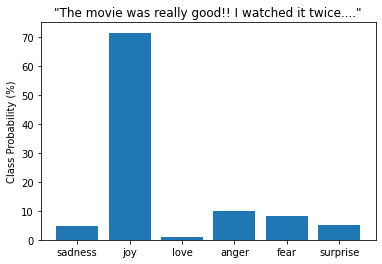

In [132]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100* preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class Probability (%)")
plt.show()